# **Advanced Smart Traffic Management using Deep Learning**

**Course:** SEP769 - Cyber Physical Systems (Deep Learning)

**Group No.:** 15

**Members:**

1. Meghal Vipulbhai Shah (400609965)
2. Shelin Sunand Vankawala (400609992)
3. Zeel Prafulbhai Patel (400605894)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout

# **Data Loading**

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SEP769_CPS(DL)_Final_Project/train_data.csv', encoding = 'ISO-8859-1', engine = 'c')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SEP769_CPS(DL)_Final_Project/test_data.csv', encoding = 'ISO-8859-1', engine = 'c')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11808 entries, 0 to 11807
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  11808 non-null  object
 1   Junction  11808 non-null  int64 
 2   ID        11808 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 276.9+ KB


In [ ]:
print(train_df.head())
print(train_df.info())
print(train_df.describe())
print(train_df['Junction'].value_counts())

              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None
           Junction      Vehicles            ID
count  48120.000000  48120.000000  4.812000e+04
mean       2.180549     22.791334  2.016330e+10
std        0.966955     20.750063  5.944854e+06
min        1.000000      1.000000  2.015110e+10
25%        1.000000      9.000000

# **Data Visualization**

###**a. Time Series Plot by Junction**

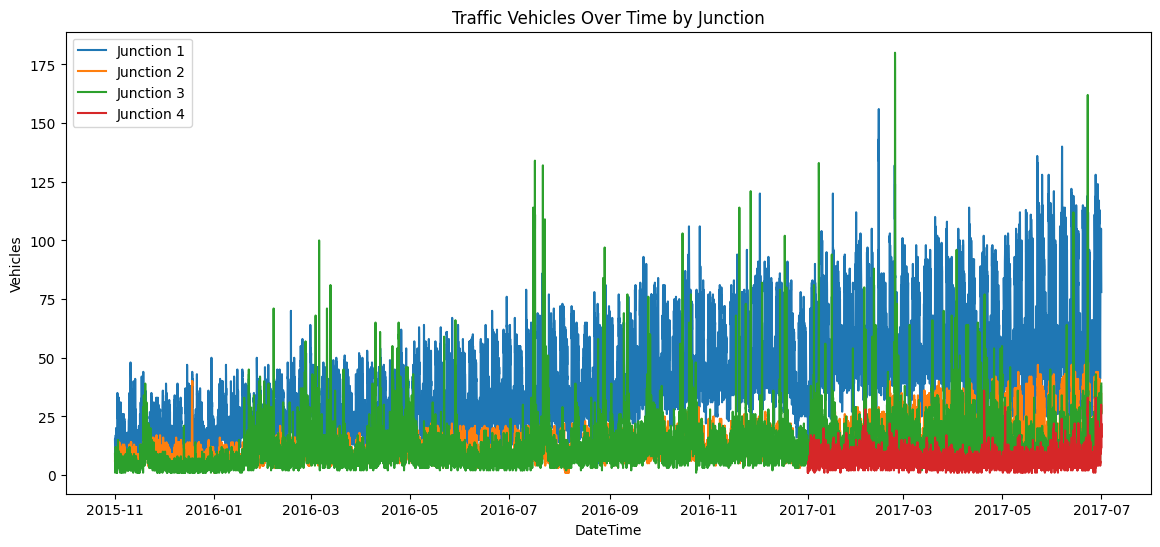

In [ ]:
plt.figure(figsize=(14, 6))
for junction in train_df['Junction'].unique():
    data = train_df[train_df['Junction'] == junction]
    plt.plot(pd.to_datetime(data['DateTime']), data['Vehicles'], label = f"Junction {junction}")
plt.xlabel("DateTime")
plt.ylabel("Vehicles")
plt.title("Traffic Vehicles Over Time by Junction")
plt.legend()
plt.show()

###**b. Distribution of Vehicles**

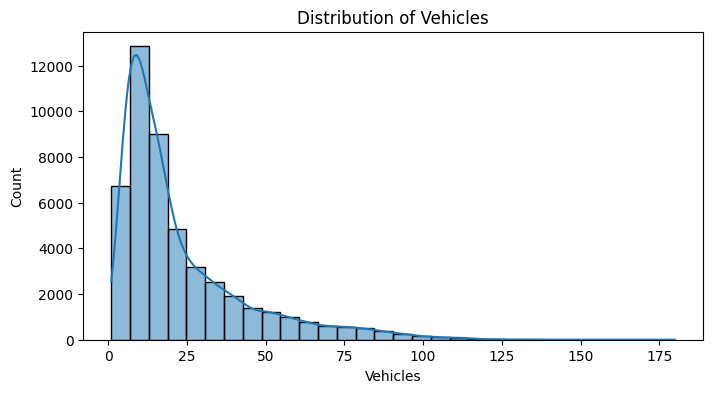

In [ ]:
plt.figure(figsize = (8, 4))
sns.histplot(train_df['Vehicles'], bins = 30, kde = True)
plt.title("Distribution of Vehicles")
plt.show()

###**c. Boxplot by Junction**

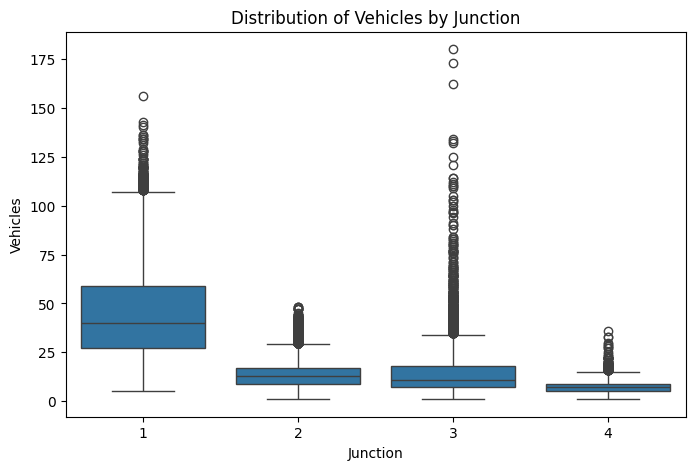

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x = 'Junction', y = 'Vehicles', data = train_df)
plt.title('Distribution of Vehicles by Junction')
plt.show()

###**d. Average Vehicles by Hour**

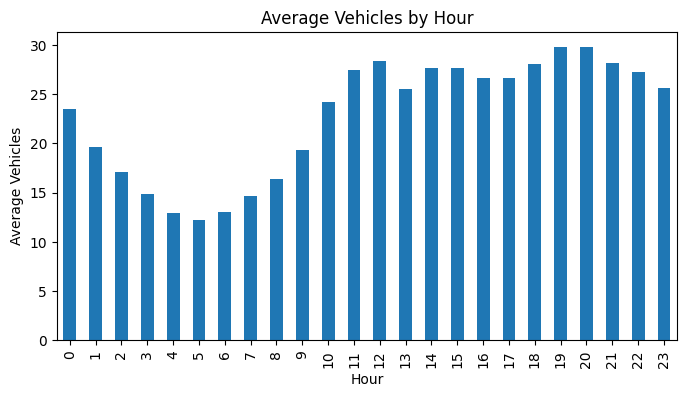

In [ ]:
train_df['Hour'] = pd.to_datetime(train_df['DateTime']).dt.hour
hourly_avg = train_df.groupby('Hour')['Vehicles'].mean()
plt.figure(figsize = (8, 4))
hourly_avg.plot(kind='bar')
plt.title('Average Vehicles by Hour')
plt.ylabel('Average Vehicles')
plt.show()

# **Feature Engineering**

In [ ]:
train_df['DateTime'] = pd.to_datetime(train_df['DateTime'])

# Extract individual components from the datetime for model input
train_df['Year'] = train_df['DateTime'].dt.year
train_df['Month'] = train_df['DateTime'].dt.month
train_df['Day'] = train_df['DateTime'].dt.day
train_df['Hour'] = train_df['DateTime'].dt.hour
train_df['Weekday'] = train_df['DateTime'].dt.weekday
train_df['WeekOfYear'] = train_df['DateTime'].dt.isocalendar().week
train_df['Is_Weekend'] = train_df['Weekday'].isin([5, 6]).astype(int)

#  Categorical variable into numeric form for modeling
le = LabelEncoder()
train_df['Junction_encoded'] = le.fit_transform(train_df['Junction'])

# **Feature Selection**

In [ ]:
feature_columns = [
    'Junction_encoded', 'Year', 'Month', 'Day', 'Hour',
    'Weekday', 'WeekOfYear', 'Is_Weekend'
]
target_column = 'Vehicles'

X = train_df[feature_columns]
y = train_df[target_column].values

#**Scale Features**

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **Train-Test Splits**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

# **1. FFN**

###**FNN: HParams Tuning**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorboard.plugins.hparams import api as hp
import datetime, os

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SEP769_CPS(DL)_Final_Project/train_data.csv', encoding = 'ISO-8859-1', engine = 'c')

# Extract date-time features
train_df['DateTime'] = pd.to_datetime(train_df['DateTime'])
train_df['Year'] = train_df['DateTime'].dt.year
train_df['Month'] = train_df['DateTime'].dt.month
train_df['Day'] = train_df['DateTime'].dt.day
train_df['Hour'] = train_df['DateTime'].dt.hour
train_df['Weekday'] = train_df['DateTime'].dt.weekday
train_df['WeekOfYear'] = train_df['DateTime'].dt.isocalendar().week
train_df['Is_Weekend'] = train_df['Weekday'].isin([5, 6]).astype(int)

# Encode categorical variable (Junction)
le = LabelEncoder()
train_df['Junction_encoded'] = le.fit_transform(train_df['Junction'])

# Define features and target
feature_columns = [
    'Junction_encoded', 'Year', 'Month', 'Day', 'Hour',
    'Weekday', 'WeekOfYear', 'Is_Weekend'
]

target_column = 'Vehicles'
X = train_df[feature_columns]
y = train_df[target_column].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

HP_UNITS1 = hp.HParam('units1', hp.Discrete([128, 256]))
HP_UNITS2 = hp.HParam('units2', hp.Discrete([64, 128]))
HP_DROPOUT1 = hp.HParam('dropout1', hp.RealInterval(0.2, 0.4))
HP_DROPOUT2 = hp.HParam('dropout2', hp.RealInterval(0.1, 0.3))
HP_LR = hp.HParam('lr', hp.Discrete([0.001, 0.005]))
HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([32, 64]))

METRIC_MAE = 'mae'
METRIC_MSE = 'mse'
METRIC_RMSE = 'rmse'

# Model building

def build_ffnn_hparams(hparams, input_shape):
    model = keras.Sequential([
        Dense(hparams[HP_UNITS1], activation = 'relu', input_shape = (input_shape,)),
        Dropout(hparams[HP_DROPOUT1]),
        Dense(hparams[HP_UNITS2], activation = 'relu'),
        Dropout(hparams[HP_DROPOUT2]),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=hparams[HP_LR])
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])
    return model

log_dir = 'logs/hparam_tuning/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

with tf.summary.create_file_writer(log_dir).as_default():
    hp.hparams_config(
        hparams = [HP_UNITS1, HP_UNITS2, HP_DROPOUT1, HP_DROPOUT2, HP_LR, HP_BATCH_SIZE],
        metrics = [hp.Metric(METRIC_MAE, display_name = 'val_MAE')],
    )

# Experiment runner function
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record values used in this trial
        model = build_ffnn_hparams(hparams, X_train.shape[1])
        history = model.fit(
            X_train, y_train,
            validation_data = (X_val, y_val),
            epochs = 30,
            batch_size = hparams[HP_BATCH_SIZE],
            verbose = 0
        )
        y_pred = model.predict(X_val)
        val_mae = mean_absolute_error(y_val, y_pred)
        tf.summary.scalar(METRIC_MAE, val_mae, step = 1)
        print(f"Trial MAE: {val_mae:.4f}")

# Search grid
session_num = 0
for units1 in HP_UNITS1.domain.values:
    for units2 in HP_UNITS2.domain.values:
        for dropout1 in np.linspace(HP_DROPOUT1.domain.min_value, HP_DROPOUT1.domain.max_value, 2):
            for dropout2 in np.linspace(HP_DROPOUT2.domain.min_value, HP_DROPOUT2.domain.max_value, 2):
                for lr in HP_LR.domain.values:
                    for batch_size in HP_BATCH_SIZE.domain.values:
                        hparams = {
                            HP_UNITS1: units1,
                            HP_UNITS2: units2,
                            HP_DROPOUT1: dropout1,
                            HP_DROPOUT2: dropout2,
                            HP_LR: lr,
                            HP_BATCH_SIZE: batch_size
                        }
                        run_name = f'run-{session_num}'
                        print(f'--- Starting trial: {run_name}')
                        print({h.name: hparams[h] for h in hparams})
                        run(os.path.join(log_dir, run_name), hparams)
                        session_num += 1

print("\nTo view results, run in a new cell:")
print("%load_ext tensorboard")
print(f"%tensorboard --logdir {log_dir}")

--- Starting trial: run-0
{'units1': 128, 'units2': 64, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.1), 'lr': 0.001, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.4788
--- Starting trial: run-1
{'units1': 128, 'units2': 64, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.1), 'lr': 0.001, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.4721
--- Starting trial: run-2
{'units1': 128, 'units2': 64, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.1), 'lr': 0.005, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.3501
--- Starting trial: run-3
{'units1': 128, 'units2': 64, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.1), 'lr': 0.005, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.5426
--- Starting trial: run-4
{'units1': 128, 'units2': 64, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.3), 'lr': 0.001, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.4786
--- Starting trial: run-5
{'units1': 128, 'units2': 64, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.3), 'lr': 0.001, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.5368
--- Starting trial: run-6
{'units1': 128, 'units2': 64, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.3), 'lr': 0.005, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.6081
--- Starting trial: run-7
{'units1': 128, 'units2': 64, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.3), 'lr': 0.005, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.5575
--- Starting trial: run-8
{'units1': 128, 'units2': 64, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.1), 'lr': 0.001, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.7109
--- Starting trial: run-9
{'units1': 128, 'units2': 64, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.1), 'lr': 0.001, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.6908
--- Starting trial: run-10
{'units1': 128, 'units2': 64, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.1), 'lr': 0.005, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.7227
--- Starting trial: run-11
{'units1': 128, 'units2': 64, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.1), 'lr': 0.005, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.9008
--- Starting trial: run-12
{'units1': 128, 'units2': 64, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.3), 'lr': 0.001, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.7508
--- Starting trial: run-13
{'units1': 128, 'units2': 64, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.3), 'lr': 0.001, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.7263
--- Starting trial: run-14
{'units1': 128, 'units2': 64, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.3), 'lr': 0.005, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.8348
--- Starting trial: run-15
{'units1': 128, 'units2': 64, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.3), 'lr': 0.005, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.9757
--- Starting trial: run-16
{'units1': 128, 'units2': 128, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.1), 'lr': 0.001, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.3816
--- Starting trial: run-17
{'units1': 128, 'units2': 128, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.1), 'lr': 0.001, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.3103
--- Starting trial: run-18
{'units1': 128, 'units2': 128, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.1), 'lr': 0.005, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.1925
--- Starting trial: run-19
{'units1': 128, 'units2': 128, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.1), 'lr': 0.005, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.2900
--- Starting trial: run-20
{'units1': 128, 'units2': 128, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.3), 'lr': 0.001, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.4122
--- Starting trial: run-21
{'units1': 128, 'units2': 128, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.3), 'lr': 0.001, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.4323
--- Starting trial: run-22
{'units1': 128, 'units2': 128, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.3), 'lr': 0.005, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.5209
--- Starting trial: run-23
{'units1': 128, 'units2': 128, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.3), 'lr': 0.005, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.4373
--- Starting trial: run-24
{'units1': 128, 'units2': 128, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.1), 'lr': 0.001, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.8102
--- Starting trial: run-25
{'units1': 128, 'units2': 128, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.1), 'lr': 0.001, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.7111
--- Starting trial: run-26
{'units1': 128, 'units2': 128, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.1), 'lr': 0.005, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.9986
--- Starting trial: run-27
{'units1': 128, 'units2': 128, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.1), 'lr': 0.005, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.7844
--- Starting trial: run-28
{'units1': 128, 'units2': 128, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.3), 'lr': 0.001, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.6772
--- Starting trial: run-29
{'units1': 128, 'units2': 128, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.3), 'lr': 0.001, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.5428
--- Starting trial: run-30
{'units1': 128, 'units2': 128, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.3), 'lr': 0.005, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 4.0169
--- Starting trial: run-31
{'units1': 128, 'units2': 128, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.3), 'lr': 0.005, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.7519
--- Starting trial: run-32
{'units1': 256, 'units2': 64, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.1), 'lr': 0.001, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.4507
--- Starting trial: run-33
{'units1': 256, 'units2': 64, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.1), 'lr': 0.001, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.3579
--- Starting trial: run-34
{'units1': 256, 'units2': 64, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.1), 'lr': 0.005, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.2265
--- Starting trial: run-35
{'units1': 256, 'units2': 64, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.1), 'lr': 0.005, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.3439
--- Starting trial: run-36
{'units1': 256, 'units2': 64, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.3), 'lr': 0.001, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Trial MAE: 3.4328
--- Starting trial: run-37
{'units1': 256, 'units2': 64, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.3), 'lr': 0.001, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.5008
--- Starting trial: run-38
{'units1': 256, 'units2': 64, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.3), 'lr': 0.005, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Trial MAE: 3.4371
--- Starting trial: run-39
{'units1': 256, 'units2': 64, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.3), 'lr': 0.005, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.4967
--- Starting trial: run-40
{'units1': 256, 'units2': 64, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.1), 'lr': 0.001, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Trial MAE: 3.4758
--- Starting trial: run-41
{'units1': 256, 'units2': 64, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.1), 'lr': 0.001, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Trial MAE: 3.5534
--- Starting trial: run-42
{'units1': 256, 'units2': 64, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.1), 'lr': 0.005, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.5619
--- Starting trial: run-43
{'units1': 256, 'units2': 64, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.1), 'lr': 0.005, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.4685
--- Starting trial: run-44
{'units1': 256, 'units2': 64, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.3), 'lr': 0.001, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.6503
--- Starting trial: run-45
{'units1': 256, 'units2': 64, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.3), 'lr': 0.001, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.5098
--- Starting trial: run-46
{'units1': 256, 'units2': 64, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.3), 'lr': 0.005, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.5904
--- Starting trial: run-47
{'units1': 256, 'units2': 64, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.3), 'lr': 0.005, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.4136
--- Starting trial: run-48
{'units1': 256, 'units2': 128, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.1), 'lr': 0.001, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.3043
--- Starting trial: run-49
{'units1': 256, 'units2': 128, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.1), 'lr': 0.001, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.4661
--- Starting trial: run-50
{'units1': 256, 'units2': 128, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.1), 'lr': 0.005, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.1924
--- Starting trial: run-51
{'units1': 256, 'units2': 128, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.1), 'lr': 0.005, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.2252
--- Starting trial: run-52
{'units1': 256, 'units2': 128, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.3), 'lr': 0.001, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.1819
--- Starting trial: run-53
{'units1': 256, 'units2': 128, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.3), 'lr': 0.001, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.4565
--- Starting trial: run-54
{'units1': 256, 'units2': 128, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.3), 'lr': 0.005, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.5786
--- Starting trial: run-55
{'units1': 256, 'units2': 128, 'dropout1': np.float64(0.2), 'dropout2': np.float64(0.3), 'lr': 0.005, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Trial MAE: 3.3102
--- Starting trial: run-56
{'units1': 256, 'units2': 128, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.1), 'lr': 0.001, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.4714
--- Starting trial: run-57
{'units1': 256, 'units2': 128, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.1), 'lr': 0.001, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.3415
--- Starting trial: run-58
{'units1': 256, 'units2': 128, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.1), 'lr': 0.005, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.5096
--- Starting trial: run-59
{'units1': 256, 'units2': 128, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.1), 'lr': 0.005, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.3857
--- Starting trial: run-60
{'units1': 256, 'units2': 128, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.3), 'lr': 0.001, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.4672
--- Starting trial: run-61
{'units1': 256, 'units2': 128, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.3), 'lr': 0.001, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.4549
--- Starting trial: run-62
{'units1': 256, 'units2': 128, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.3), 'lr': 0.005, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.3980
--- Starting trial: run-63
{'units1': 256, 'units2': 128, 'dropout1': np.float64(0.4), 'dropout2': np.float64(0.3), 'lr': 0.005, 'batch_size': 64}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Trial MAE: 3.5284

To view results, run in a new cell:
%load_ext tensorboard
%tensorboard --logdir logs/hparam_tuning/20250803-223932


###**Final FNN Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Building model
def build_ffnn(input_shape):
    model = Sequential([
        Dense(256, activation = 'relu', input_shape = (input_shape,)),
        Dropout(0.3),
        Dense(128, activation = 'relu'),
        Dropout(0.2),
        Dense(64, activation = 'relu'),
        Dense(1)
    ])
    model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mse', metrics = ['mae', 'mse'])
    return model

ffnn = build_ffnn(X_train.shape[1])
ffnn.summary()

# Training model
history_ffnn = ffnn.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 30,
    batch_size = 64,
    verbose = 1
)

# Validation Prediction & Evaluation
y_pred_ffnn = ffnn.predict(X_val)

mae = mean_absolute_error(y_val, y_pred_ffnn)
mse = mean_squared_error(y_val, y_pred_ffnn)
rmse = np.sqrt(mse)
print("FNN MAE:", mae)
print("FNN MSE:", mse)
print("FNN RMSE:", rmse)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_192 (Dense)               │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_128 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,521 (170.00 KB)

 Trainable params: 43,521 (170.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 275.1624 - mae: 10.3241 - mse: 275.1624 - val_loss: 62.6710 - val_mae: 5.0664 - val_mse: 62.6710
Epoch 2/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 68.7291 - mae: 5.4283 - mse: 68.7291 - val_loss: 41.6063 - val_mae: 3.9680 - val_mse: 41.6063
Epoch 3/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 52.8598 - mae: 4.6769 - mse: 52.8598 - val_loss: 38.0997 - val_mae: 3.8776 - val_mse: 38.0997
Epoch 4/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 46.3152 - mae: 4.3937 - mse: 46.3152 - val_loss: 37.4291 - val_mae: 3.7045 - val_mse: 37.4291
Epoch 5/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 49.2412 - mae: 4.4100 - mse: 49.2412 - val_loss: 37.1877 - val_mae: 3.7284 - val_mse: 37.1877
Epoch 6/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 49.0418 - mae: 4.3366 - mse: 49.0418 - val_loss: 36.6962 - val_mae: 3.6557 - val_mse: 36.6962
Epoch 7/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 45.5459 - mae

# **2. LSTM**

###**LSTM: HParams Tuning**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorboard.plugins.hparams import api as hp
import datetime, os

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SEP769_CPS(DL)_Final_Project/train_data.csv', encoding='ISO-8859-1', engine='c')

# Extract date-time features
train_df['DateTime'] = pd.to_datetime(train_df['DateTime'])
train_df['Year'] = train_df['DateTime'].dt.year
train_df['Month'] = train_df['DateTime'].dt.month
train_df['Day'] = train_df['DateTime'].dt.day
train_df['Hour'] = train_df['DateTime'].dt.hour
train_df['Weekday'] = train_df['DateTime'].dt.weekday
train_df['WeekOfYear'] = train_df['DateTime'].dt.isocalendar().week
train_df['Is_Weekend'] = train_df['Weekday'].isin([5, 6]).astype(int)

# Encode categorical features
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['Junction_encoded'] = le.fit_transform(train_df['Junction'])

# Feature columns and target column
feature_columns = ['Junction_encoded', 'Year', 'Month', 'Day', 'Hour', 'Weekday', 'WeekOfYear', 'Is_Weekend']
target_column = 'Vehicles'
X = train_df[feature_columns]
y = train_df[target_column].values

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape for LSTM
X_train_lstm = X_train.reshape((-1, 1, X_train.shape[1]))
X_val_lstm = X_val.reshape((-1, 1, X_val.shape[1]))

# Hyperparameters for tuning
HP_UNITS1 = hp.HParam('units1', hp.Discrete([128, 256]))
HP_UNITS2 = hp.HParam('units2', hp.Discrete([64, 128]))
HP_DROPOUT1 = hp.HParam('dropout1', hp.RealInterval(0.2, 0.4))
HP_DROPOUT2 = hp.HParam('dropout2', hp.RealInterval(0.1, 0.3))
HP_LR = hp.HParam('lr', hp.Discrete([0.001, 0.005]))
HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([32, 64]))

METRIC_MAE = 'mae'
METRIC_MSE = 'mse'
METRIC_RMSE = 'rmse'

# Model building
def build_lstm_hparams(hparams, input_shape):
    model = keras.Sequential([
        LSTM(hparams[HP_UNITS1], return_sequences = True, input_shape = input_shape),
        Dropout(hparams[HP_DROPOUT1]),
        LSTM(hparams[HP_UNITS2]),
        Dropout(hparams[HP_DROPOUT2]),
        Dense(32, activation = 'relu'),
        Dense(1)
    ])
    optimizer = Adam(learning_rate = hparams[HP_LR])
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae', 'mse'])
    return model

log_dir = 'logs/hparam_tuning/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

with tf.summary.create_file_writer(log_dir).as_default():
    hp.hparams_config(
        hparams=[HP_UNITS1, HP_UNITS2, HP_DROPOUT1, HP_DROPOUT2, HP_LR, HP_BATCH_SIZE],
        metrics=[hp.Metric(METRIC_MAE, display_name = 'val_MAE'),
                 hp.Metric(METRIC_MSE, display_name = 'val_MSE'),
                 hp.Metric(METRIC_RMSE, display_name = 'val_RMSE')],
    )

# Experiment runner function
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        model = build_lstm_hparams(hparams, (X_train_lstm.shape[1], X_train_lstm.shape[2]))
        history = model.fit(
            X_train_lstm, y_train,
            validation_data = (X_val_lstm, y_val),
            epochs = 30,
            batch_size = hparams[HP_BATCH_SIZE],
            verbose = 0
        )

        y_pred = model.predict(X_val_lstm)

        val_mae = mean_absolute_error(y_val, y_pred)
        val_mse = mean_squared_error(y_val, y_pred)
        val_rmse = np.sqrt(val_mse)

        tf.summary.scalar(METRIC_MAE, val_mae, step=1)
        tf.summary.scalar(METRIC_MSE, val_mse, step=1)
        tf.summary.scalar(METRIC_RMSE, val_rmse, step=1)

        print(f"Trial MAE: {val_mae:.4f}, MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}")

# Search grid
session_num = 0
for units1 in HP_UNITS1.domain.values:
    for units2 in HP_UNITS2.domain.values:
        for dropout1 in np.linspace(HP_DROPOUT1.domain.min_value, HP_DROPOUT1.domain.max_value, 2):
            for dropout2 in np.linspace(HP_DROPOUT2.domain.min_value, HP_DROPOUT2.domain.max_value, 2):
                for lr in HP_LR.domain.values:
                    for batch_size in HP_BATCH_SIZE.domain.values:
                        hparams = {
                            HP_UNITS1: units1,
                            HP_UNITS2: units2,
                            HP_DROPOUT1: dropout1,
                            HP_DROPOUT2: dropout2,
                            HP_LR: lr,
                            HP_BATCH_SIZE: batch_size
                        }
                        run_name = f'run-{session_num}'
                        print(f'--- Starting trial: {run_name}')
                        print({h.name: hparams[h] for h in hparams})
                        run(os.path.join(log_dir, run_name), hparams)
                        session_num += 1

print("\nTo view results, run in a new cell:")
print("%load_ext tensorboard")
print(f"%tensorboard --logdir {log_dir}")

###**Final LSTM Model**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Feature and Target
X = train_df[feature_columns].values
y = train_df[target_column].values

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

# Reshape
X_train_lstm = X_train.reshape((-1, 1, X_train.shape[1]))
X_val_lstm = X_val.reshape((-1, 1, X_val.shape[1]))

# Building model
def build_lstm(input_shape):
    model = Sequential([
        LSTM(128, return_sequences = True, input_shape = input_shape),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation = 'relu'),
        Dense(1)
    ])
    model.compile(optimizer = Adam(learning_rate = 0.001), loss='mse', metrics = ['mae', 'mse'])
    return model

lstm_model = build_lstm((X_train_lstm.shape[1], X_train_lstm.shape[2]))

history_lstm = lstm_model.fit(
    X_train_lstm, y_train,
    validation_data = (X_val_lstm, y_val),
    epochs = 30,
    batch_size = 64,
    verbose = 1
)

# Validation Prediction & Evaluation
y_pred_lstm = lstm_model.predict(X_val_lstm)

val_mae = mean_absolute_error(y_val, y_pred_lstm)
val_mse = mean_squared_error(y_val, y_pred_lstm)
val_rmse = np.sqrt(val_mse)
print("LSTM MAE:", val_mae)
print("LSTM MSE:", val_mse)
print("LSTM RMSE:", val_rmse)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


602/602 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 462.0809 - mae: 14.1118 - mse: 462.0809 - val_loss: 77.4067 - val_mae: 5.9112 - val_mse: 77.4067
Epoch 2/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 86.4549 - mae: 6.2904 - mse: 86.4549 - val_loss: 66.4926 - val_mae: 5.4619 - val_mse: 66.4926
Epoch 3/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 77.9761 - mae: 5.8453 - mse: 77.9761 - val_loss: 52.8578 - val_mae: 4.6915 - val_mse: 52.8578
Epoch 4/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 61.6914 - mae: 5.1776 - mse: 61.6914 - val_loss: 46.4460 - val_mae: 4.3804 - val_mse: 46.4460
Epoch 5/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 56.5742 - mae: 4.8815 - mse: 56.5742 - val_loss: 43.6716 - val_mae: 4.2243 - val_mse: 43.6716
Epoch 6/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 56.7889 - mae: 4.7798 - mse: 56.7889 - val_loss: 41.6913 - val_mae: 4.0815 - val_mse: 41.6913
Epoch 7/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 52.2837 - mae: 4.6779 - 

# **3. GRU**

###**GRU: HParams**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorboard.plugins.hparams import api as hp
import datetime, os

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SEP769_CPS(DL)_Final_Project/train_data.csv', encoding='ISO-8859-1', engine='c')

# Feature Engineering
train_df['DateTime'] = pd.to_datetime(train_df['DateTime'])
train_df['Year'] = train_df['DateTime'].dt.year
train_df['Month'] = train_df['DateTime'].dt.month
train_df['Day'] = train_df['DateTime'].dt.day
train_df['Hour'] = train_df['DateTime'].dt.hour
train_df['Weekday'] = train_df['DateTime'].dt.weekday
train_df['WeekOfYear'] = train_df['DateTime'].dt.isocalendar().week
train_df['Is_Weekend'] = train_df['Weekday'].isin([5, 6]).astype(int)

# Label Encoding
le = LabelEncoder()
train_df['Junction_encoded'] = le.fit_transform(train_df['Junction'])

# Feature Columns & Target
feature_columns = ['Junction_encoded', 'Year', 'Month', 'Day', 'Hour', 'Weekday', 'WeekOfYear', 'Is_Weekend']
target_column = 'Vehicles'
X = train_df[feature_columns]
y = train_df[target_column].values

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape
X_train_gru = X_train.reshape((-1, 1, X_train.shape[1]))
X_val_gru = X_val.reshape((-1, 1, X_val.shape[1]))

# Hyperparameter Tuning
HP_UNITS1 = hp.HParam('units1', hp.Discrete([64, 128, 256]))
HP_UNITS2 = hp.HParam('units2', hp.Discrete([32, 64, 128]))
HP_DROPOUT1 = hp.HParam('dropout1', hp.RealInterval(0.2, 0.4))
HP_DROPOUT2 = hp.HParam('dropout2', hp.RealInterval(0.2, 0.4))
HP_LR = hp.HParam('lr', hp.Discrete([0.001, 0.005]))
HP_BATCH_SIZE = hp.HParam('batch_size', hp.Discrete([32, 64]))

METRIC_MAE = 'mae'
METRIC_MSE = 'mse'
METRIC_RMSE = 'rmse'

# Building model
def build_gru(hparams, input_shape):
    model = Sequential([
        GRU(hparams[HP_UNITS1], return_sequences = True, input_shape = input_shape),
        Dropout(hparams[HP_DROPOUT1]),
        GRU(hparams[HP_UNITS2]),
        Dropout(hparams[HP_DROPOUT2]),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    optimizer = Adam(learning_rate = hparams[HP_LR])
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])
    return model

# Tensorboard Logging Setup
log_dir = 'logs/hparam_tuning/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

with tf.summary.create_file_writer(log_dir).as_default():
    hp.hparams_config(
        hparams=[HP_UNITS1, HP_UNITS2, HP_DROPOUT1, HP_DROPOUT2, HP_LR, HP_BATCH_SIZE],
        metrics=[hp.Metric(METRIC_MAE, display_name='val_MAE'),
                 hp.Metric(METRIC_MSE, display_name='val_MSE'),
                 hp.Metric(METRIC_RMSE, display_name='val_RMSE')],
    )

# Experiment runner function
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record values used in this trial
        model = build_gru(hparams, (X_train_gru.shape[1], X_train_gru.shape[2]))
        history = model.fit(
            X_train_gru, y_train,
            validation_data=(X_val_gru, y_val),
            epochs=30,
            batch_size=hparams[HP_BATCH_SIZE],
            verbose=0
        )

        # Validation Predictions
        y_pred_gru = model.predict(X_val_gru)

        # Calculate MAE, MSE, and RMSE
        val_mae = mean_absolute_error(y_val, y_pred_gru)
        val_mse = mean_squared_error(y_val, y_pred_gru)
        val_rmse = np.sqrt(val_mse)

        # Log metrics to TensorBoard
        tf.summary.scalar(METRIC_MAE, val_mae, step = 1)
        tf.summary.scalar(METRIC_MSE, val_mse, step = 1)
        tf.summary.scalar(METRIC_RMSE, val_rmse, step = 1)

        print(f"Trial MAE: {val_mae:.4f}, MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}")

# Run Hyperparameter Search Grid
session_num = 0
for units1 in HP_UNITS1.domain.values:
    for units2 in HP_UNITS2.domain.values:
        for dropout1 in np.linspace(HP_DROPOUT1.domain.min_value, HP_DROPOUT1.domain.max_value, 2):
            for dropout2 in np.linspace(HP_DROPOUT2.domain.min_value, HP_DROPOUT2.domain.max_value, 2):
                for lr in HP_LR.domain.values:
                    for batch_size in HP_BATCH_SIZE.domain.values:
                        hparams = {
                            HP_UNITS1: units1,
                            HP_UNITS2: units2,
                            HP_DROPOUT1: dropout1,
                            HP_DROPOUT2: dropout2,
                            HP_LR: lr,
                            HP_BATCH_SIZE: batch_size
                        }
                        run_name = f'run-{session_num}'
                        print(f'--- Starting trial: {run_name}')
                        print({h.name: hparams[h] for h in hparams})
                        run(os.path.join(log_dir, run_name), hparams)
                        session_num += 1

# Launch TensorBoard
print("\nTo view results, run in a new cell:")
print("%load_ext tensorboard")
print(f"%tensorboard --logdir {log_dir}")

###**Final GRU Model**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Feature and Target
X = train_df[feature_columns].values
y = train_df[target_column].values

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape for GRU
X_train_gru = X_train.reshape((-1, 1, X_train.shape[1]))
X_val_gru = X_val.reshape((-1, 1, X_val.shape[1]))

# Building model
def build_gru(input_shape):
    model = Sequential([
        GRU(128, return_sequences = True, input_shape = input_shape),
        Dropout(0.3),
        GRU(64),
        Dropout(0.2),
        Dense(32, activation = 'relu'),
        Dense(1)
    ])
    model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mse', metrics = ['mae', 'mse'])
    return model

gru_model = build_gru((X_train_gru.shape[1], X_train_gru.shape[2]))

# Training
history_gru = gru_model.fit(
    X_train_gru, y_train,
    validation_data = (X_val_gru, y_val),
    epochs = 30,
    batch_size = 64,
    verbose = 1
)

# Validation Prediction & Evaluation
y_pred_gru = gru_model.predict(X_val_gru)

mae = mean_absolute_error(y_val, y_pred_gru)
mse = mean_squared_error(y_val, y_pred_gru)
rmse = np.sqrt(mse)
print("GRU MAE:", mae)
print("GRU MSE:", mse)
print("GRU RMSE:", rmse)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


602/602 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 398.2702 - mae: 13.1038 - mse: 398.2702 - val_loss: 72.9821 - val_mae: 5.6627 - val_mse: 72.9821
Epoch 2/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 85.2748 - mae: 6.1996 - mse: 85.2748 - val_loss: 61.3021 - val_mae: 5.1330 - val_mse: 61.3021
Epoch 3/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 72.8076 - mae: 5.6374 - mse: 72.8076 - val_loss: 50.9018 - val_mae: 4.5979 - val_mse: 50.9018
Epoch 4/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 64.2268 - mae: 5.2636 - mse: 64.2268 - val_loss: 44.9608 - val_mae: 4.3064 - val_mse: 44.9608
Epoch 5/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 56.6155 - mae: 4.9434 - mse: 56.6155 - val_loss: 41.5806 - val_mae: 4.0382 - val_mse: 41.5806
Epoch 6/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 51.9819 - mae: 4.7259 - mse: 51.9819 - val_loss: 39.8564 - val_mae: 4.0069 - val_mse: 39.8564
Epoch 7/30
602/602 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 50.6840 - mae: 4.5863 - 

# **Loss/MAE Curves During Training**

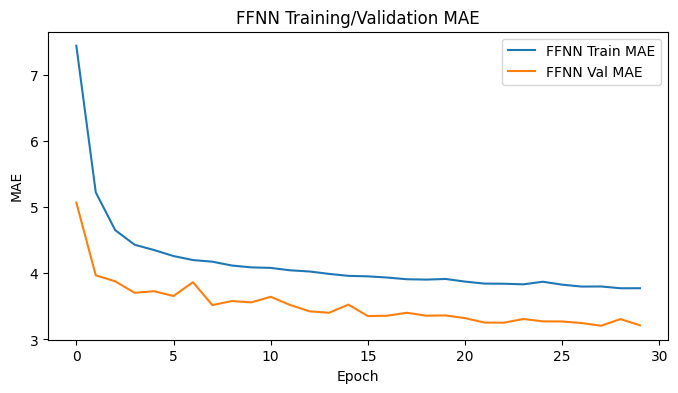

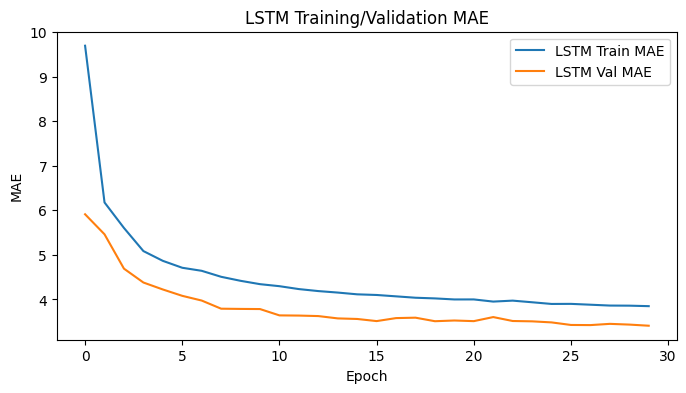

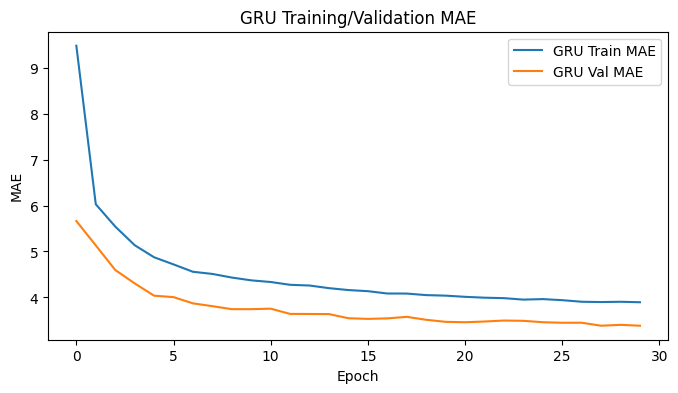

In [ ]:
import matplotlib.pyplot as plt

# FNN
plt.figure(figsize=(8,4))
plt.plot(history_ffnn.history['mae'], label='FFNN Train MAE')
plt.plot(history_ffnn.history['val_mae'], label='FFNN Val MAE')
plt.title('FFNN Training/Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# LSTM
plt.figure(figsize=(8,4))
plt.plot(history_lstm.history['mae'], label='LSTM Train MAE')
plt.plot(history_lstm.history['val_mae'], label='LSTM Val MAE')
plt.title('LSTM Training/Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

# GRU
plt.figure(figsize=(8,4))
plt.plot(history_gru.history['mae'], label='GRU Train MAE')
plt.plot(history_gru.history['val_mae'], label='GRU Val MAE')
plt.title('GRU Training/Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

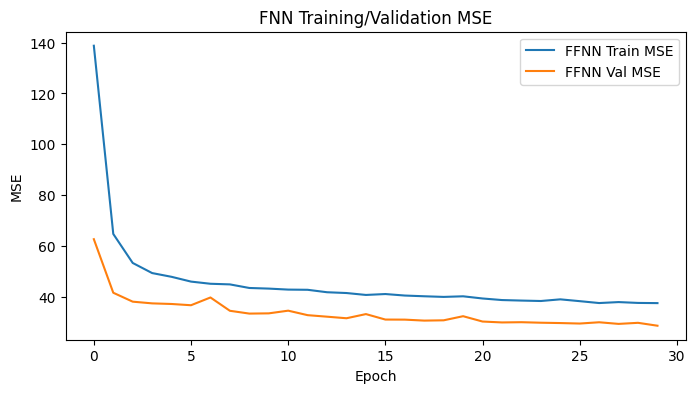

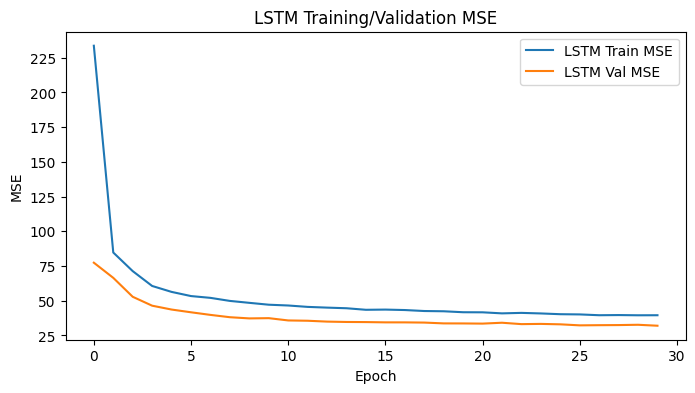

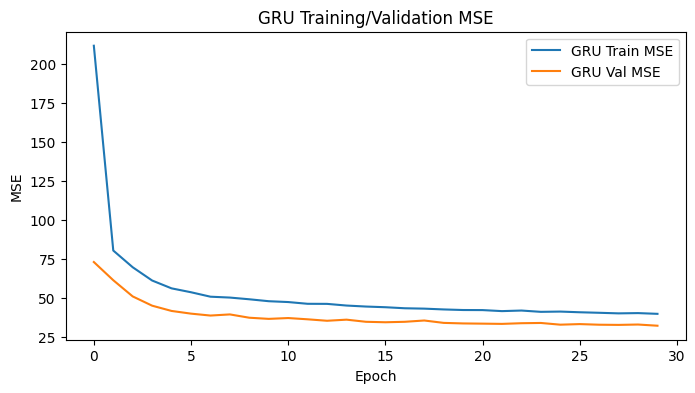

In [ ]:
import matplotlib.pyplot as plt

# FNN: MSE Plot
plt.figure(figsize=(8,4))
plt.plot(history_ffnn.history['mse'], label='FFNN Train MSE')
plt.plot(history_ffnn.history['val_mse'], label='FFNN Val MSE')
plt.title('FNN Training/Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# LSTM: MSE Plot
plt.figure(figsize=(8,4))
plt.plot(history_lstm.history['mse'], label='LSTM Train MSE')
plt.plot(history_lstm.history['val_mse'], label='LSTM Val MSE')
plt.title('LSTM Training/Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# GRU: MSE Plot
plt.figure(figsize=(8,4))
plt.plot(history_gru.history['mse'], label='GRU Train MSE')
plt.plot(history_gru.history['val_mse'], label='GRU Val MSE')
plt.title('GRU Training/Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# **Actual vs Predicted Scatter Plots**

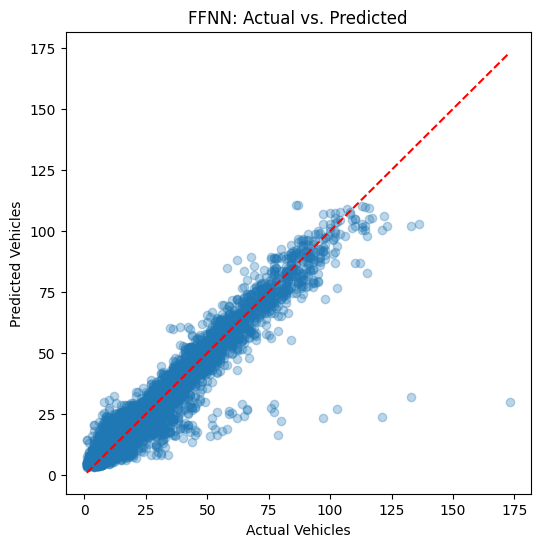

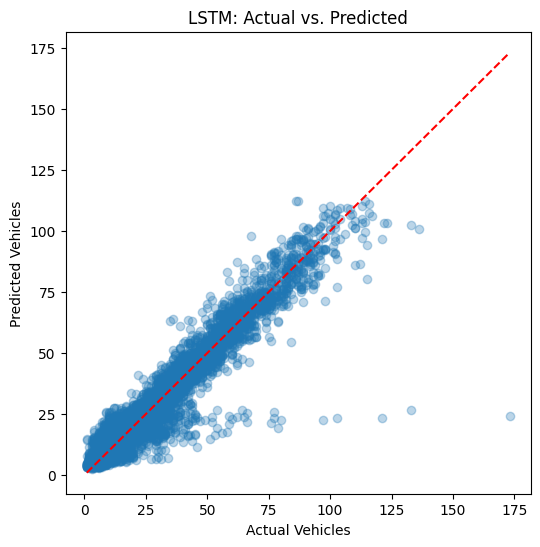

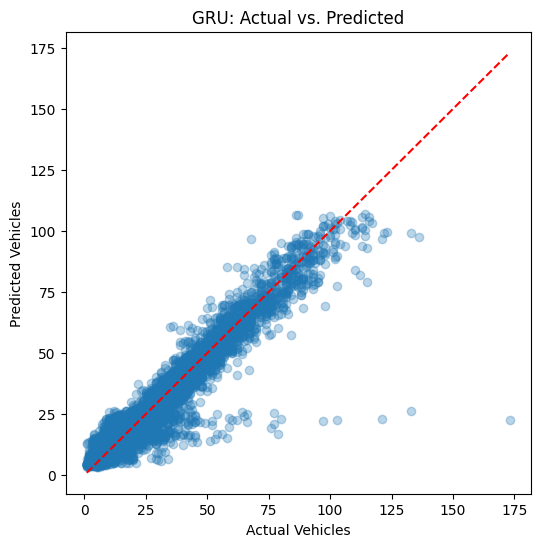

In [ ]:
# FNN
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_ffnn, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')
plt.title('FFNN: Actual vs. Predicted')
plt.show()

# LSTM
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_lstm, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')
plt.title('LSTM: Actual vs. Predicted')
plt.show()

# GRU
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_gru, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual Vehicles')
plt.ylabel('Predicted Vehicles')
plt.title('GRU: Actual vs. Predicted')
plt.show()

#**References**

[1]		TensorFlow Documentation – https://www.tensorflow.org\

[2]		Keras API – https://keras.io

[3]		TensorBoard Hyperparameter Tuning -https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams

[4]		Research Literature on Deep Learning for Time-Series Forecasting

[5]		Kaggle Datasets - https://www.kaggle.com/datasets/fedesoriano/traffic-prediction-dataset

[6]		City of Toronto Smart Mobility Initiatives – https://www.toronto.ca/services-payments/streets-parking-transportation/smart-mobility/

[7]		IBM Urban Insights: Smart City Traffic Analytics

[8]		Urban Mobility Planning Reports (UN Habitat, McKinsey Global Institute)
